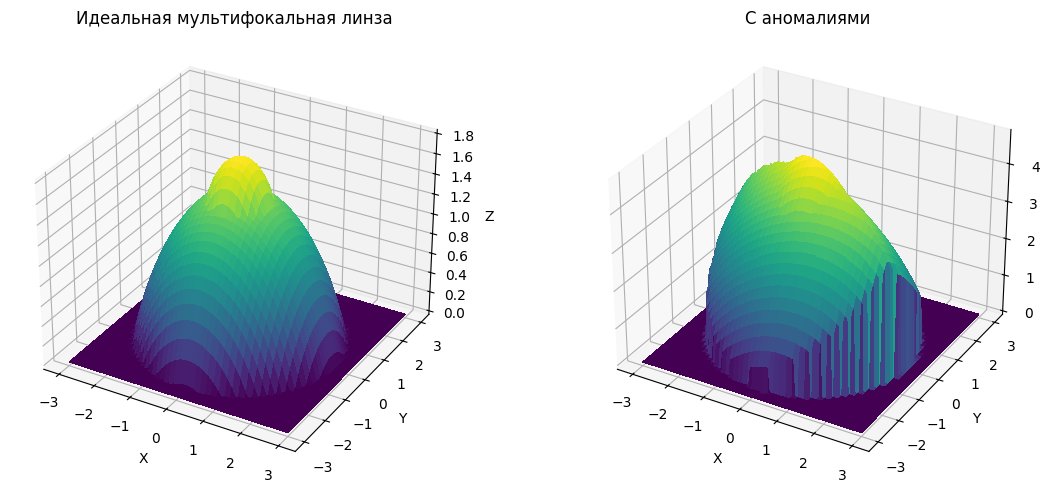

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def multifocal(Rs, Zs, X, Y, dx=0, dy=0, dz=0, tilt_x=0, tilt_y=0, coma_x=0, coma_y=0, 
               cylinder_radius=0, cylinder_angle=0, cylinder_height=0):
    """
    Rs, Zs — радиусы и смещения сегментов
    X, Y — координатные сетки
    dx, dy, dz — смещение линзы
    tilt_x, tilt_y — наклоны (в радианах)
    coma_x, coma_y — коэффициенты комы по x и y
    cylinder_radius — радиус цилиндра
    cylinder_angle — угол поворота цилиндра (в радианах)
    cylinder_height — высота цилиндрической грани
    """
    EPS = 1e-2
    N = X.shape[0]
    Z = np.zeros((N, N))
    
    # Применяем смещение координат
    Xp = X - dx
    Yp = Y - dy
    
    # Вычисляем профиль многослойной линзы
    for R, zz in zip(Rs, Zs):
        mask = R**2 - Xp**2 - Yp**2 > 0
        Z_candidate = np.sqrt(np.clip(R**2 - Xp**2 - Yp**2, 0, None)) + zz + dz
        Z[mask] = np.maximum(Z[mask], Z_candidate[mask])
    
    # Создаем маску ненулевых точек (где есть волновой фронт)
    wavefront_mask = Z > EPS
    
    # Добавляем наклон ТОЛЬКО к волновому фронту
    Z_tilt = X * np.tan(tilt_x) + Y * np.tan(tilt_y)
    Z += Z_tilt
    
    # Добавляем цилиндрическую грань
    if cylinder_radius > 0 and cylinder_height > 0:
        # Поворачиваем координаты на угол цилиндра
        X_rot = X * np.cos(cylinder_angle) + Y * np.sin(cylinder_angle)
        Y_rot = -X * np.sin(cylinder_angle) + Y * np.cos(cylinder_angle)
        
        # Создаем цилиндрическую грань (боковая поверхность цилиндра)
        # Грань поднимается там, где X_rot приближается к cylinder_radius
        cylinder_mask = np.abs(X_rot) <= cylinder_radius
        cylinder_profile = cylinder_height * (1 - np.abs(X_rot) / cylinder_radius)
        
        # Добавляем цилиндрическую грань ко всему волновому фронту
        Z[wavefront_mask] += cylinder_profile[wavefront_mask] * cylinder_mask[wavefront_mask]
    
    # Добавляем кому (асимметричное искажение)
    rho = np.sqrt(X**2 + Y**2)
    theta = np.arctan2(Y, X)
    W_coma = (3 * rho**3 - 2 * rho) * (coma_x * np.cos(theta) + coma_y * np.sin(theta))
    
    # Применяем кому ТОЛЬКО к волновому фронту
    Z[wavefront_mask] += W_coma[wavefront_mask]
    
    return Z


# ===== Пример использования =====

# Сетка
N = 128
x = np.linspace(-3, 3, N)
y = np.linspace(-3, 3, N)
X, Y = np.meshgrid(x, y)

# Параметры многослойной линзы
Rs = [3.0, 2.0, 1.5]
Zs = [0.0, 0.2, 0.4]

Rs = [1, 3]
Zs = [0.8, -1.5]

# Без искажений
Z0 = multifocal(Rs, Zs, X, Y)

# С аномалиями: смещение, наклон и кома
'''Z_anom = multifocal(Rs, Zs, X, Y,
                    dx=0.2, dy=0.1, tilt_x=np.deg2rad(3), tilt_y=np.deg2rad(2),
                    coma_x=0.02, coma_y=-0.015)'''
                    
Z_anom = multifocal(Rs, Zs, X, Y,
                    dx=0, dy=0, tilt_x=0, tilt_y=0,
                    coma_x=0, coma_y=0, cylinder_radius=3, cylinder_angle=6*np.pi / 15, cylinder_height=3)

# ===== Визуализация =====
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z0, cmap='viridis', linewidth=0, antialiased=False)
ax1.set_title("Идеальная мультифокальная линза")
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, Z_anom, cmap='viridis', linewidth=0, antialiased=False)
ax2.set_title("С аномалиями")
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()


In [46]:
# Добавлять абберацию кома только к самой линзе Сделано

In [47]:
#обуччить параметры для каждой аномалии и всех вместе

In [48]:
# прибавляется цилиндр края приподняты Сделано
# подключить фантазию, какие вещи еще могут быть Сделано
# поискать по контекстам специфические абберации Сделано
# фиксировать количество варьируемых параметров Сделано
# На входе наклоны => методом получаю поверхность => ищу параметры аномалий

In [49]:
from method import method_v

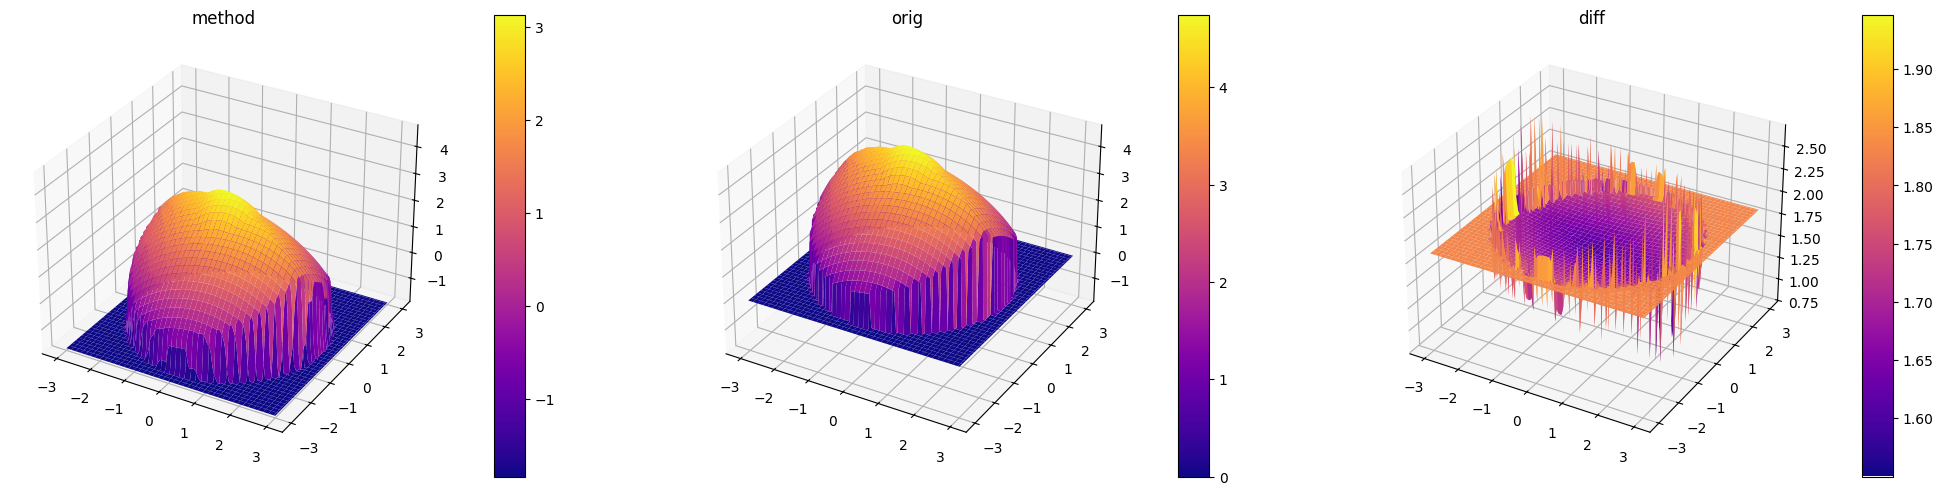

In [50]:
z_approx = method_v(Z_anom, N, 3, 0)

Zmin = min(z_approx.min(), Z_anom.min())
Zmax = max(z_approx.max(), Z_anom.max())

fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(131, projection='3d')
surf1 = ax.plot_surface(X, Y, z_approx, cmap='plasma')
ax.set_title('method')
ax.set_zlim([Zmin, Zmax])
ax.view_init(30, -60)
fig.colorbar(surf1, shrink=0.6, aspect=15, pad=0.1)

ax = fig.add_subplot(132, projection='3d')
surf2 = ax.plot_surface(X, Y, Z_anom, cmap='plasma')
ax.set_title('orig')
ax.set_zlim([Zmin, Zmax])
# ax.set_zlim([0, np.max((z_approx - offs))])
ax.view_init(30, -60)
fig.colorbar(surf2, shrink=0.6, aspect=15, pad=0.1)

ax = fig.add_subplot(133, projection='3d')
surf2 = ax.plot_surface(X, Y, abs(Z_anom - z_approx), cmap='plasma')
ax.set_title('diff')
#ax.set_zlim([Zmin, Zmax])
# ax.set_zlim([0, np.max((z_approx - offs))])
ax.view_init(30, -60)
fig.colorbar(surf2, shrink=0.6, aspect=15, pad=0.1)
plt.show()


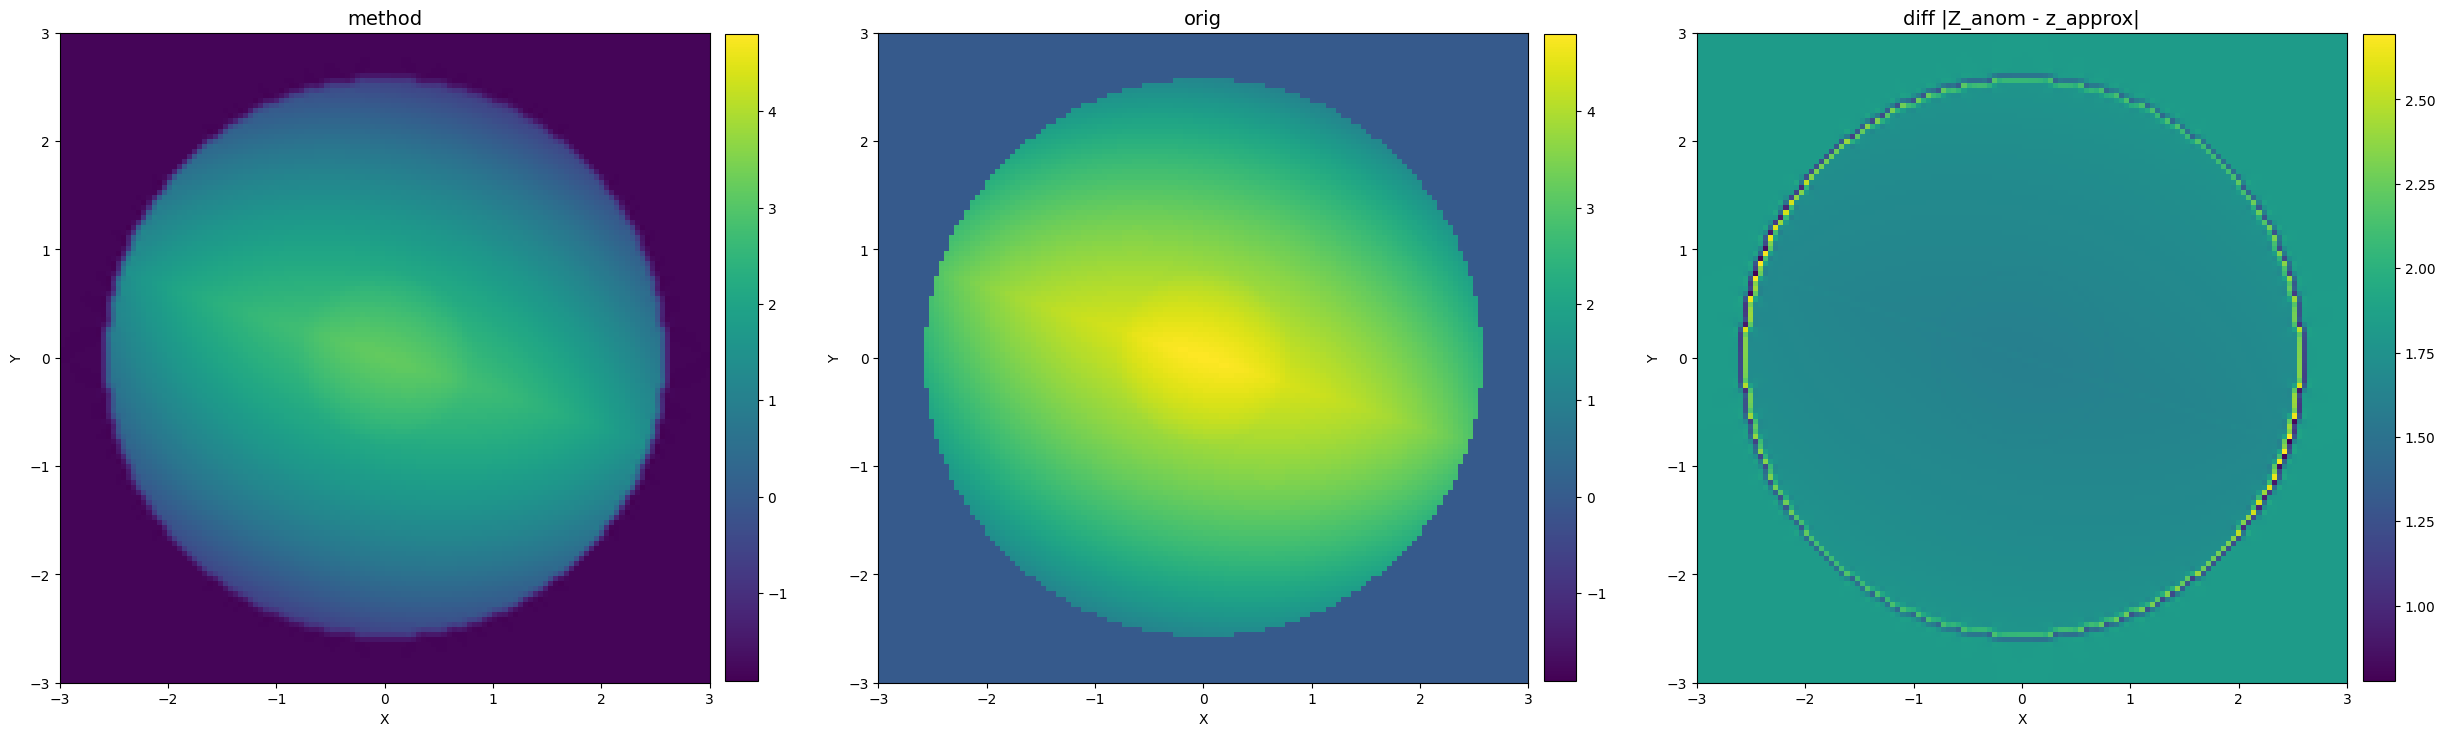

In [51]:
Zmin = min(z_approx.min(), Z_anom.min())
Zmax = max(z_approx.max(), Z_anom.max())

fig, axes = plt.subplots(1, 3, figsize=(25, 8))

# --- 1. method ---
im1 = axes[0].imshow(z_approx, extent=[X.min(), X.max(), Y.min(), Y.max()],
                     origin='lower', cmap='viridis', vmin=Zmin, vmax=Zmax)
axes[0].set_title('method', fontsize=14)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
fig.colorbar(im1, ax=axes[0], shrink=0.84, aspect=20, pad=0.02)

# --- 2. orig ---
im2 = axes[1].imshow(Z_anom, extent=[X.min(), X.max(), Y.min(), Y.max()],
                     origin='lower', cmap='viridis', vmin=Zmin, vmax=Zmax)
axes[1].set_title('orig', fontsize=14)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
fig.colorbar(im2, ax=axes[1], shrink=0.84, aspect=20, pad=0.02)

# --- 3. diff ---
diff = np.abs(Z_anom - z_approx)
im3 = axes[2].imshow(diff, extent=[X.min(), X.max(), Y.min(), Y.max()],
                     origin='lower', cmap='viridis')
axes[2].set_title('diff |Z_anom - z_approx|', fontsize=14)
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
fig.colorbar(im3, ax=axes[2], shrink=0.84, aspect=20, pad=0.02)

plt.tight_layout()
plt.show()


In [52]:
from skimage.metrics import mean_squared_error as mse

In [53]:
mse(Z_anom, z_approx)

np.float64(3.070034702042051)

In [54]:
def shiftrow(arr, shift):  # Сдвиг строк
    arr = np.roll(arr, axis=0, shift=shift)
    # arr[shift, :] = arr[shift - 1, :]
    return arr


def shiftcolumn(arr, shift):  # Сдвиг столбцов
    arr = np.roll(arr, axis=1, shift=shift)
    # arr[:, shift] = arr[:, shift - 1]
    return arr


def fx(func, pnt_cnt, edge):  # Частная производная по x
    d = 2 * edge / pnt_cnt
    return (shiftrow(func, pnt_cnt - 1) - shiftrow(func, 1)) / (2 * d)


def fy(func, pnt_cnt, edge):  # Частная производная по y
    d = 2 * edge / pnt_cnt
    return (shiftcolumn(func, pnt_cnt - 1) - shiftcolumn(func, 1)) / (2 * d)

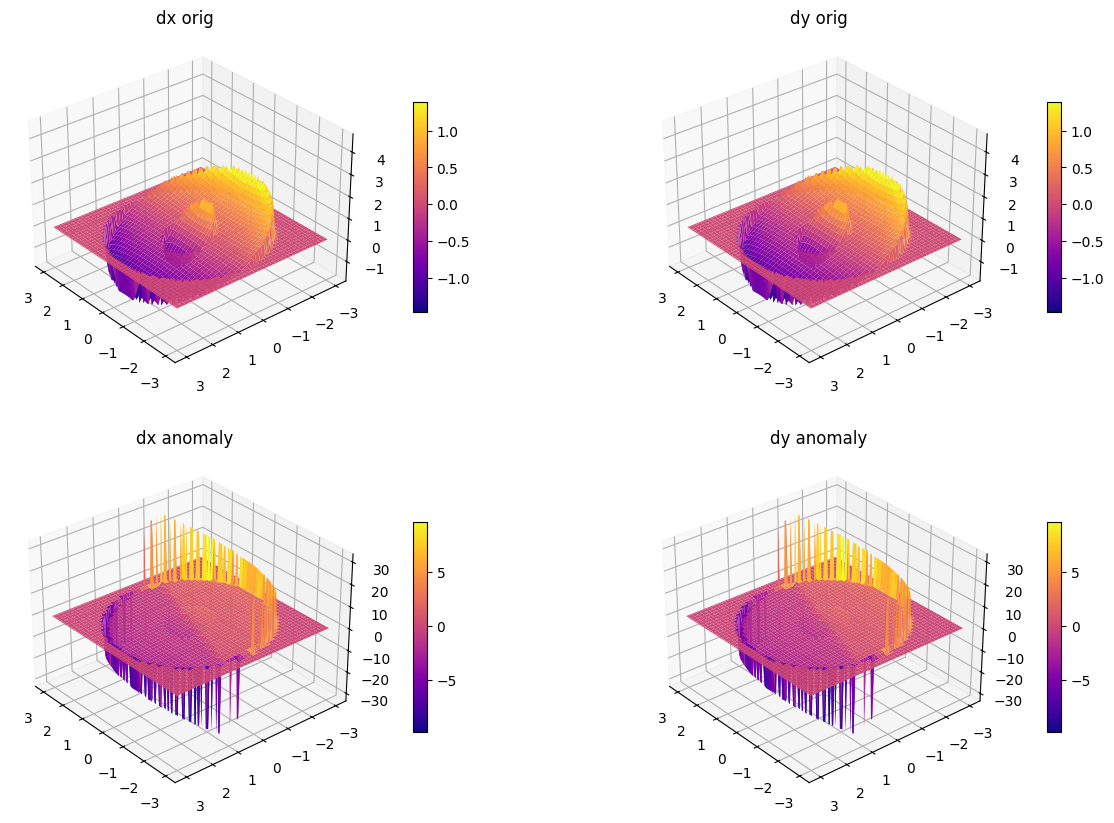

In [55]:
dx2 = fx(Z_anom, N, 3)
dy2 = fx(Z_anom, N, 3)

dx = fx(Z0, N, 3)
dy = fx(Z0, N, 3)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(221, projection='3d')
surf1 = ax.plot_surface(X, Y, dx, cmap='plasma')
ax.set_title('dx orig')
ax.set_zlim([Zmin, Zmax])
ax.view_init(30, 140)
fig.colorbar(surf1, shrink=0.6, aspect=15, pad=0.1)

ax = fig.add_subplot(222, projection='3d')
surf2 = ax.plot_surface(X, Y, dy, cmap='plasma')
ax.set_title('dy orig')
ax.set_zlim([Zmin, Zmax])
# ax.set_zlim([0, np.max((z_approx - offs))])
ax.view_init(30, 140)
fig.colorbar(surf2, shrink=0.6, aspect=15, pad=0.1)

ax = fig.add_subplot(223, projection='3d')
surf2 = ax.plot_surface(X, Y, dx2, cmap='plasma')
ax.set_title('dx anomaly')
#ax.set_zlim([Zmin, Zmax])
# ax.set_zlim([0, np.max((z_approx - offs))])
ax.view_init(30, 140)
fig.colorbar(surf2, shrink=0.6, aspect=15, pad=0.1)

ax = fig.add_subplot(224, projection='3d')
surf2 = ax.plot_surface(X, Y, dy2, cmap='plasma')
ax.set_title('dy anomaly')
#ax.set_zlim([Zmin, Zmax])
# ax.set_zlim([0, np.max((z_approx - offs))])
ax.view_init(30, 140)
fig.colorbar(surf2, shrink=0.6, aspect=15, pad=0.1)
plt.show()

In [56]:
center = N // 2

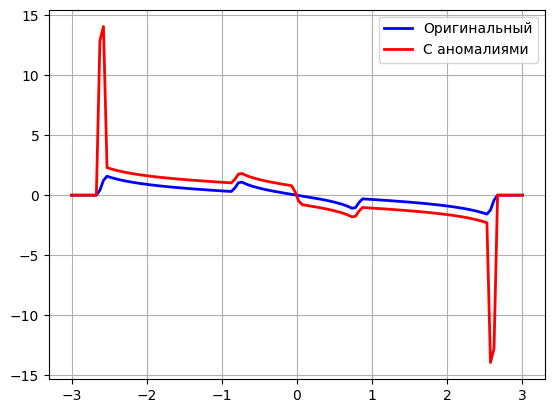

In [57]:
plt.plot(x, dy[:, center], 'b-', label='Оригинальный', linewidth=2)
plt.plot(x, dy2[:, center], 'r-', label='С аномалиями', linewidth=2)
#plt.plot(x, (fyy_normal + alphas[0][1])[:, center], 'g-', label='Без наклонов со сдвигом', linewidth=2)
#plt.set_title('Сечение ∂Z/∂X')
#plt.ylim(-2, 2)
plt.legend()
plt.grid(True)
plt.show()